In [187]:
import pandas as pd
from matplotlib import pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
from sklearn.preprocessing import LabelEncoder

# Data preparing

In [188]:
data = pd.read_csv('./data/data.csv')
data

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate
0,Albania,2012,2.404087,12319.779604,-4.430218,Apples,369.7,3.2
1,Albania,2012,2.404087,12319.779604,-4.430218,Apricots,489.9,3.2
2,Albania,2012,2.404087,12319.779604,-4.430218,Barley,316.1,3.2
3,Albania,2012,2.404087,12319.779604,-4.430218,"Beans, dry",1562.2,3.2
4,Albania,2012,2.404087,12319.779604,-4.430218,Cabbages,203.4,3.2
...,...,...,...,...,...,...,...,...
15644,Switzerland,2022,1.661019,818426.550206,0.616880,Tomatoes,3407.9,2.7
15645,Switzerland,2022,1.661019,818426.550206,0.616880,Triticale,362.4,2.7
15646,Switzerland,2022,1.661019,818426.550206,0.616880,Unmanufactured tobacco,16495.0,2.7
15647,Switzerland,2022,1.661019,818426.550206,0.616880,"Walnuts, in shell",3498.0,2.7


In [189]:
data['Difference of inflation'] = data['Food Inflation Rate'] - data['Overall Inflation Rate']

In [190]:
mean_value = data['Difference of inflation'].mean()
std_dev = data['Difference of inflation'].std()
mean_value, std_dev

(0.6515898678563061, 1.8824104304769327)

In [191]:
threshold = mean_value + std_dev

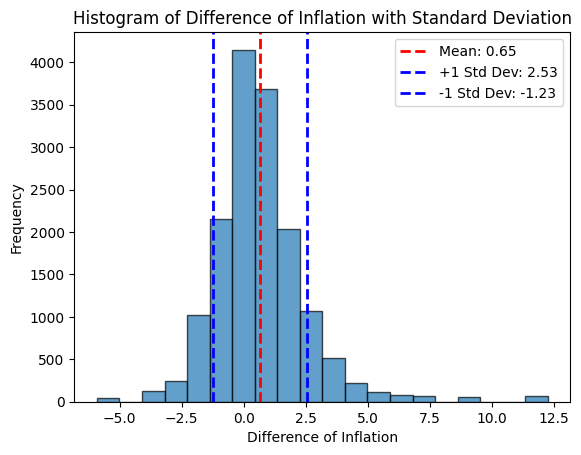

In [192]:
plt.hist(data['Difference of inflation'], bins=20, edgecolor='black', alpha=0.7)

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + std_dev, color='blue', linestyle='dashed', linewidth=2,
            label=f'+1 Std Dev: {mean_value + std_dev:.2f}')
plt.axvline(mean_value - std_dev, color='blue', linestyle='dashed', linewidth=2,
            label=f'-1 Std Dev: {mean_value - std_dev:.2f}')

plt.title('Histogram of Difference of Inflation with Standard Deviation')
plt.xlabel('Difference of Inflation')
plt.ylabel('Frequency')

plt.legend()

plt.show()

In [193]:
data['label'] = data['Difference of inflation'].apply(lambda x: 1 if x > threshold else 0)

In [194]:
data = data.drop(columns='Difference of inflation')

In [195]:
data.head()

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate,label
0,Albania,2012,2.404087,12319.779604,-4.430218,Apples,369.7,3.2,0
1,Albania,2012,2.404087,12319.779604,-4.430218,Apricots,489.9,3.2,0
2,Albania,2012,2.404087,12319.779604,-4.430218,Barley,316.1,3.2,0
3,Albania,2012,2.404087,12319.779604,-4.430218,"Beans, dry",1562.2,3.2,0
4,Albania,2012,2.404087,12319.779604,-4.430218,Cabbages,203.4,3.2,0


In [196]:
numerical_columns=['Food Inflation Rate', 'Raw GDP', 'GDP Growth Rate','Item Price Per Tonne', 'Overall Inflation Rate', 'Year']

Uncomment this code for encoding with binary encoder

In [197]:
# binary_encoder = ce.BinaryEncoder(cols=['Item', 'Area'])
# data = binary_encoder.fit_transform(data)

Uncomment this code for encoding with label encoder

In [198]:
label_encoder = LabelEncoder()
data['Item'] = label_encoder.fit_transform(data['Item'])
data['Area'] = label_encoder.fit_transform(data['Area'])
numerical_columns.append('Item')
numerical_columns.append('Area')

In [199]:
scaler = RobustScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [200]:
data.head()

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate,label
0,-0.941176,-0.833333,0.160705,-0.422628,-0.784202,-1.000000,-0.299190,0.708333,0
1,-0.941176,-0.833333,0.160705,-0.422628,-0.784202,-0.986667,-0.229156,0.708333,0
2,-0.941176,-0.833333,0.160705,-0.422628,-0.784202,-0.906667,-0.330420,0.708333,0
3,-0.941176,-0.833333,0.160705,-0.422628,-0.784202,-0.893333,0.395618,0.708333,0
4,-0.941176,-0.833333,0.160705,-0.422628,-0.784202,-0.813333,-0.396085,0.708333,0


# Model training and evaluation

Remove 'Difference of inflation' if needed

In [201]:
X, Y = data.drop(columns=['label']), data['label']

classifier = RandomForestClassifier(
    n_estimators=30,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2840
           1       0.67      0.90      0.77       290

    accuracy                           0.95      3130
   macro avg       0.83      0.93      0.87      3130
weighted avg       0.96      0.95      0.95      3130



In [202]:
y_test.value_counts()

label
0    2738
1     392
Name: count, dtype: int64

# SHAP explainability

In [203]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x_test)

The following plots and graphs illustrate the reasoning behind the model's decision to assign a label of 1, indicating that food fraud has been detected in a specific area and year. While these visualizations are focused on the label of 1, the insights they provide can be similarly interpreted for cases where the label is 0, as the reasoning will be analogous. Therefore, we have chosen to execute them primarily for the label of 1. SHAP values quantify the contribution of each feature to a model's prediction for a given instance, providing understanding into how features impact the output. These values are retrieved based on the values in x_test, since this is the part of the dataset predictions are made on.

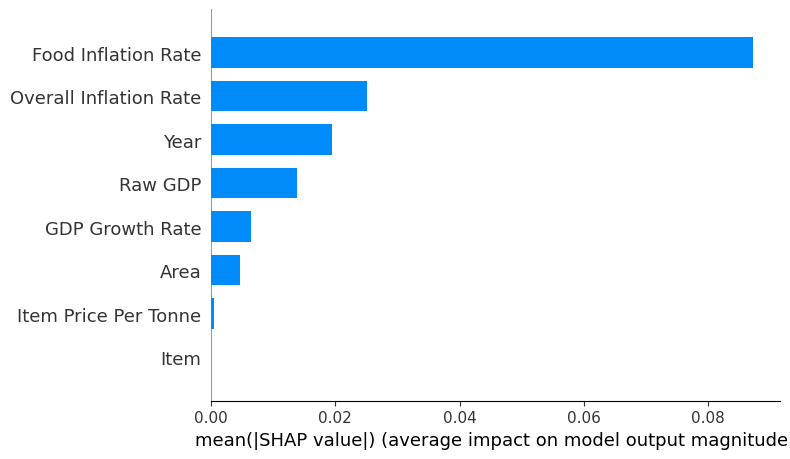

In [204]:
shap.summary_plot(shap_values[:, :, 1], x_test, plot_type="bar")

The plot above shows the average impact of each feature on the model output. The results were expected, since these two columns provide the most information when it comes to detecting food fraud. However, this plot is based on the absolute SHAP values, not taking into account whether the features affect the model output positively or negatively.

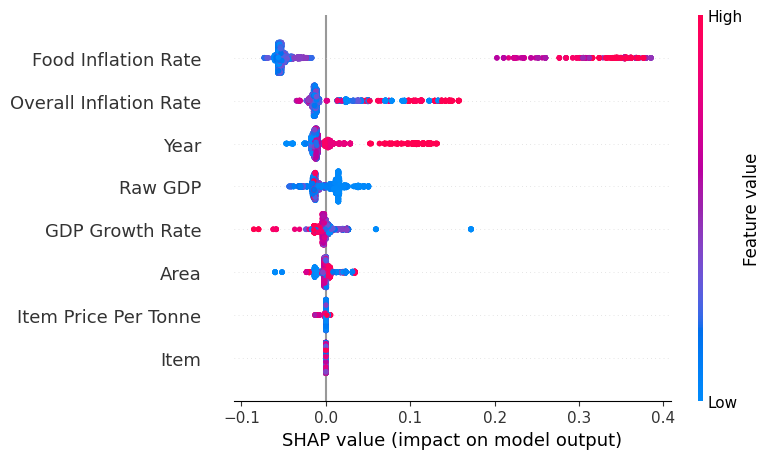

In [205]:
shap.summary_plot(shap_values[:, :, 1], x_test)

This plot also visualizes the impact of each feature on the model's output, showing how each feature contributes to the prediction. Additionally, it highlights the most important features, their direction (positive or negative impact), and the distribution of SHAP values across all samples.

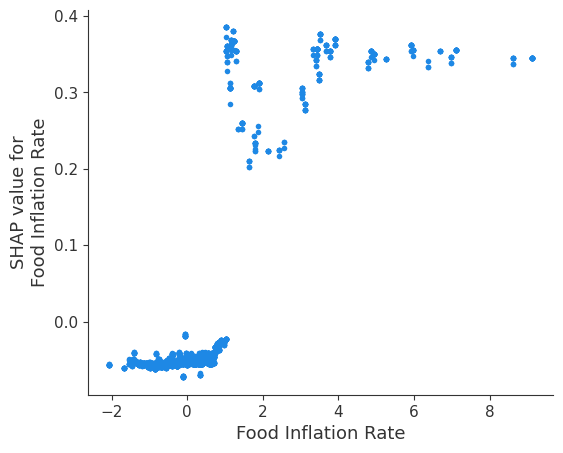

In [206]:
shap.dependence_plot("Food Inflation Rate", shap_values[:, :, 1], x_test, interaction_index=None)

This graph indicates that higher food inflation rate values have a greater impact on the model output (higher SHAP values).

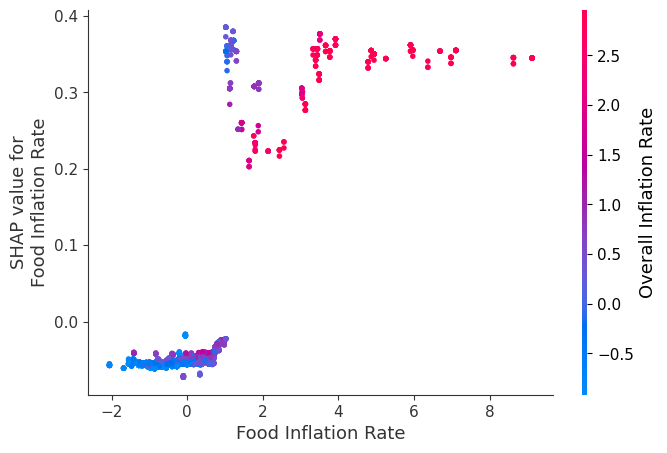

In [207]:
shap.dependence_plot('Food Inflation Rate', shap_values[:, :, 1], x_test)

This graph provides additional insights and informs us that higher overall inflation rate values have an impact on the SHAP values of Food Inflation Rate. Subsequently, this means that there is a transitive indication of how overall inflation rate influences the model output.

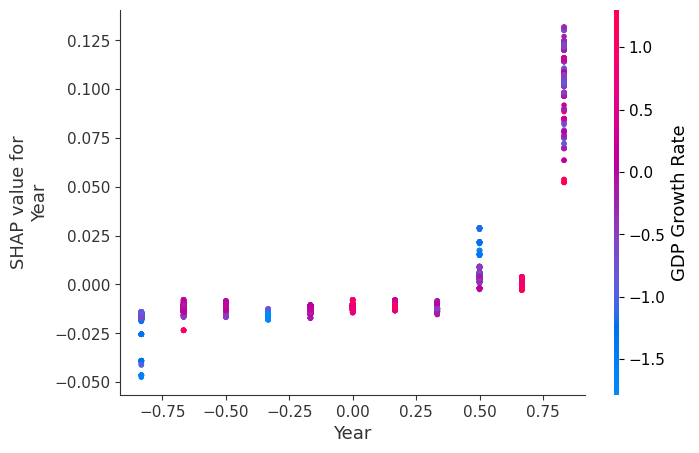

In [208]:
shap.dependence_plot(1, shap_values[:, :, 1], x_test)

This graph indicates that:
* 2012-2019: SHAP values were low, and GDP growth rates (mostly neutral to slightly positive) had little to no impact on the model.
* Around 2020: The plot shows mixed GDP growth rates, with more blue points (negative GDP growth rate), corresponding to increased   SHAP values due to economic volatility during the COVID-19 pandemic.
* 2021-2022: SHAP values peak, with mixed GDP growth rates strongly influencing the model, suggesting these years were particularly  significant, likely due to other factors like higher inflation rates.

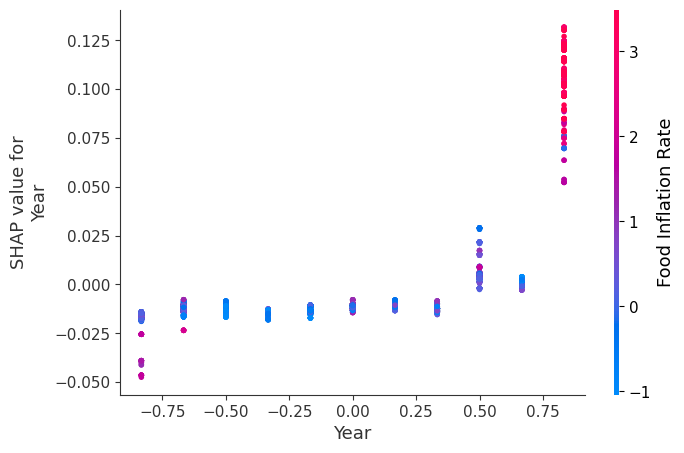

In [209]:
shap.dependence_plot('Year', shap_values[:, :, 1], x_test, interaction_index="Food Inflation Rate")

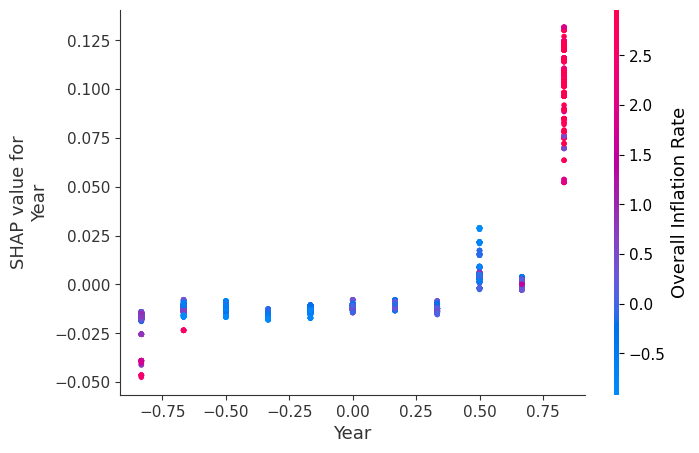

In [210]:
shap.dependence_plot('Year', shap_values[:, :, 1], x_test, interaction_index="Overall Inflation Rate")

This graph confirms what we noticed before. In 2022, the year had a big influence on the model’s output, largely due to the high Food Inflation Rate and Overall Inflation Rate, as shown in the two graphs above.

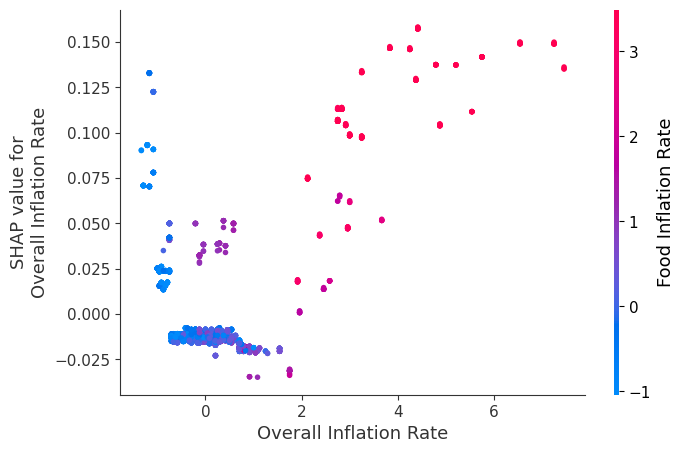

In [211]:
shap.dependence_plot("Overall Inflation Rate", shap_values[:, :, 1], x_test, interaction_index="Food Inflation Rate")

This graph adds more depth to why Overall Inflation Rate is the second-highest feature by importance, i.e. this suggests that higher values of Food Inflation Rate have a greater impact on how the Overall Inflation Rate affects the model output.

In [212]:
explainer = shap.Explainer(classifier, x_test)

In [213]:
explanation = explainer(x_test)

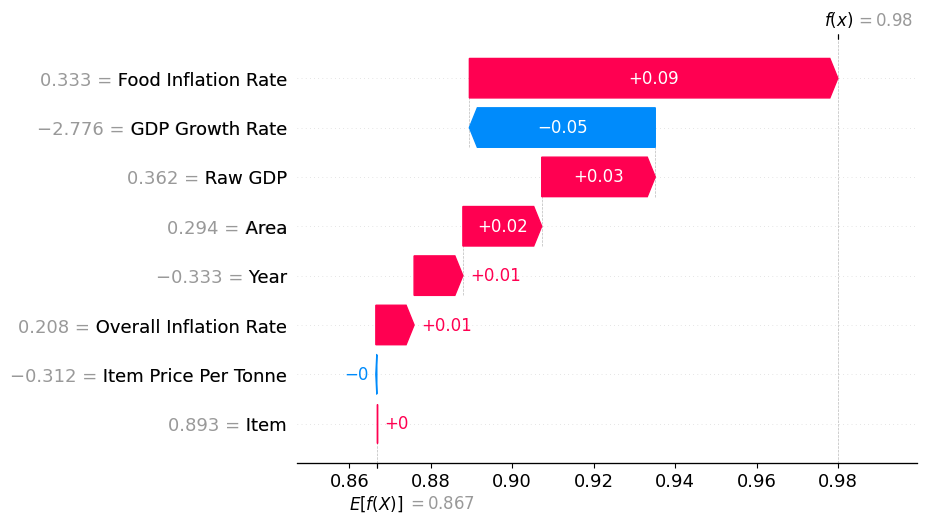

In [247]:
shap.waterfall_plot(explanation[25, :, 0])

This plot explains the output of the model through visualization of how this single row prediction is built beginning from the baseline (or "average") value, influenced by the contributions of individual features, which are sorted by the magnitude of their SHAP values. This baseline is typically the mean prediction of the model across the entire dataset, and in this case it is equal to 0.867. When it comes to the feature contributions:
* Food Inflation Rate (+0.09): This feature increases the model output significantly towards label 0(no food fraud), as it is the one for which we executed the function.
* GDP Growth Rate (-0.05): This feature decreases the model output slightly towards label 1.
* Raw GDP (+0.03), Area (+0.02), Year (+0.01), Overall Inflation Rate (+0.01): These features also contribute positively, pushing the prediction further towards 0.
* The remaining features have a negligible effect.
The model predicts 0.98, which is very close to 1. This suggests that the model is confident in predicting label 0 rather than label 1.

In [232]:
country = x_test[(x_test['Area'] > 0.293) & (x_test['Area'] < 0.295)]

In [233]:
country

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate
9965,0.294118,-0.333333,0.332531,0.362358,-2.775842,0.893333,-0.312125,0.208333
9921,0.294118,-0.500000,0.408971,0.599578,-0.804466,0.813333,1.063684,0.166667
10129,0.294118,0.333333,-0.316347,0.405349,-1.071795,0.573333,-0.164365,0.333333
10202,0.294118,0.666667,-1.414241,0.575677,3.350241,0.200000,0.502185,1.000000
9945,0.294118,-0.333333,0.332531,0.362358,-2.775842,0.106667,-0.346035,0.208333
...,...,...,...,...,...,...,...,...
9973,0.294118,-0.166667,0.220146,0.326413,-0.784594,-0.613333,0.176950,1.000000
10188,0.294118,0.666667,-1.414241,0.575677,3.350241,-0.373333,0.785702,1.000000
9842,0.294118,-0.666667,-0.318819,0.650285,-0.017184,-0.813333,0.242091,0.208333
9907,0.294118,-0.500000,0.408971,0.599578,-0.804466,0.293333,0.001340,0.166667


In [248]:
data[numerical_columns].head()

,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item Price Per Tonne,Overall Inflation Rate,Year,Item,Area
0,2.404087,12319.779604,-4.430218,369.7,3.2,2012.0,2.0,Albania
1,2.404087,12319.779604,-4.430218,489.9,3.2,2012.0,3.0,Albania
2,2.404087,12319.779604,-4.430218,316.1,3.2,2012.0,9.0,Albania
3,2.404087,12319.779604,-4.430218,1562.2,3.2,2012.0,10.0,Albania
4,2.404087,12319.779604,-4.430218,203.4,3.2,2012.0,16.0,Albania


In [218]:
data[numerical_columns] = scaler.inverse_transform(data[numerical_columns])

In [219]:
data['Area'] = data['Area'].astype(int)
data['Area'] = label_encoder.inverse_transform(data['Area'])

In [282]:
data.iloc[9965, :]

Area                             Norway
Year                             2015.0
Food Inflation Rate            2.886318
Raw GDP                   388159.512246
GDP Growth Rate              -22.636776
Item                              144.0
Item Price Per Tonne              347.5
Overall Inflation Rate              2.0
label                                 0
Name: 9965, dtype: object

In [252]:
explainer.expected_value

array([0.86675355, 0.13324645])

In [283]:
shap.initjs()
shap.plots.force(explainer.expected_value[1], shap_values[:, :, 1], x_test)

/Users/filipsamardziski/venv/lib/python3.10/site-packages/shap/plots/_force.py:208: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")


The plot above is a force plot. It visualizes the impact of features on the prediction for multiple samples:
   * X-Axis: Represents the samples sorted by some criterion (in this case, by similarity).
   * Y-Axis: Shows the SHAP values, indicating how much each feature pushed the model's output from the base value.
   * Red areas: Indicate features that increase the prediction.
   * Blue areas: Indicate features that decrease the prediction.

In [222]:
# background_data = shap.sample(x_train, 10)
# # background_data = shap.kmeans(x_train2, 10)
# explainer = shap.KernelExplainer(classifier.predict_proba, background_data)
# shap_values = explainer.shap_values(x_test)
# shap.force_plot(explainer.expected_value[0], shap_values[..., 0], x_test)